# Redes Neuronales
En este punto se pide construir dos modelos de redes neuronales, uno para regresión y otro para clasificación, considerando los datasets creados en el TP1 y mejorar estos modelos de redes neuronales a través de la búsqueda de arquitectura e hiperparámetros adecuados. Se pide:

● Regresión: predecir el precio de la propiedad y utilizar como métrica de evaluación el **error cuadrático medio**
● Clasificación: predecir el atributo tipo_precio creado en el TP 1 y utilizar como métricas **precisión, recall y F1-Score**


Breve explicación teórica:
Las redes neuronales se componen de un input, pesos, funciones: suma de los input*pesos (suma ponderada) y una función de activación, y un output. Funcionan para regresión y clasificación.
![redneuronal.png](imagenes/redneuronal.png)
Se entrenan utilizando el algoritmo de backpropagation, que lo que busca es encontrar el mínimo de la función de error dirigíendose en el sentido contrario al gradiente de la misma pero comenzando de atrás hacia adelante en la red.
Es importante destacar que son sensibles a los cambios de escala por lo que es fundamental escalar los datos para utilizar este algoritmo.
Las redes neuronales muy complejas pueden producir sobreentrenamiento. Para evitar esto usamos métodos de regularización (como L1 o L2, Dropout, Early stopping y data augmentation) y optimizadores. Estos últimos son una implementación concreta del algoritmo de backpropagation. Son ejemplos SGD (Stochastic Gradient Descent), Momentum, Nesterov, Adagrad, RMSProp, Adam, Adamax, Nadam, Adadelta.

Se realiza el import de las bibliotecas con las que se trabajarán.

In [2]:
!pip install keras_tuner==1.1.3

  Using cached keras_tuner-1.1.3-py3-none-any.whl (135 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import RandomizedSearchCV
import random as python_random

%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


# Modelo: Regresión

Se realiza la importación de los dataset de entrenamiento y testing con los que se crearán y evaluarán los modelos.

In [4]:
train = pd.read_csv("datasets/dataset_properati_train.csv")
test = pd.read_csv("datasets/dataset_properati_test.csv")

train.drop(["Unnamed: 0", "created_on", "provincia", "operation", "property_currency"], axis = 1, inplace=True)
test.drop(["Unnamed: 0", "created_on", "provincia", "operation", "property_currency"], axis = 1, inplace=True)

In [5]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    plt.figure()
    
    plt.plot(x,y,"o",label="Valores verdaderos")
    plt.plot(x,modelo.predict(x),"x",label="Valores estimados")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
display(train.head())
display(test.head())

,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,-34.611523,-58.410394,BALVANERA,Departamento,1.0,1.0,49.0,45.0,79000.0
1,-34.621782,-58.424452,ALMAGRO,Departamento,1.0,1.0,44.0,40.0,99000.0
2,-34.592425,-58.515042,VILLA DEVOTO,PH,3.0,2.0,76.0,66.0,160000.0
3,-34.607836,-58.446965,CABALLITO,Departamento,2.0,1.0,56.0,50.0,153000.0
4,-34.561456,-58.467606,BELGRANO,Departamento,2.0,1.0,55.0,45.0,159000.0


,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,-34.552834,-58.491372,SAAVEDRA,PH,5.0,3.0,158.000000,115.0,220000.0
1,-34.580101,-58.412473,PALERMO,PH,2.0,1.0,35.000000,32.0,90000.0
2,-34.598510,-58.411857,ABASTO,Departamento,2.0,1.0,43.000000,41.0,85000.0
3,-34.567515,-58.458584,BELGRANO,Departamento,2.0,1.0,111.325111,44.0,144000.0
4,-34.588866,-58.416343,PALERMO,Departamento,2.0,1.0,39.000000,36.0,105000.0


Se realiza la separación entre las columnas predictoras y la columna o variable a predecir (el precio en caso del regresor).

In [7]:
def label_encode(completo, df, campo):
    le = preprocessing.LabelEncoder()
    le.fit(completo[campo].unique())
    return le.transform(df[campo])    

In [8]:
x_train = train.drop(columns="property_price") 
y_train = train['property_price']
x_test = test.drop(columns='property_price')
y_test = test['property_price']

x_train['barrio'] = label_encode(train, x_train, 'barrio')
x_test['barrio'] = label_encode(train, x_test, 'barrio')
x_train['property_type'] = label_encode(train, x_train, 'property_type')
x_test['property_type'] = label_encode(train, x_test, 'property_type')

display(x_train.head())
display(x_test.head())

,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered
0,-34.611523,-58.410394,3,1,1.0,1.0,49.0,45.0
1,-34.621782,-58.424452,2,1,1.0,1.0,44.0,40.0
2,-34.592425,-58.515042,47,2,3.0,2.0,76.0,66.0
3,-34.607836,-58.446965,9,1,2.0,1.0,56.0,50.0
4,-34.561456,-58.467606,6,1,2.0,1.0,55.0,45.0


,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered
0,-34.552834,-58.491372,37,2,5.0,3.0,158.000000,115.0
1,-34.580101,-58.412473,26,2,2.0,1.0,35.000000,32.0
2,-34.598510,-58.411857,0,1,2.0,1.0,43.000000,41.0
3,-34.567515,-58.458584,6,1,2.0,1.0,111.325111,44.0
4,-34.588866,-58.416343,26,1,2.0,1.0,39.000000,36.0


Escalamos los datos

In [9]:
sscaler = StandardScaler()
sscaler.fit(pd.DataFrame(x_train))
x_train_transform = sscaler.transform(pd.DataFrame(x_train))
x_test_transform = sscaler.transform(pd.DataFrame(x_test))

Probamos primero con un modelo elegido al azar:

In [10]:
d_in= x_test.shape[1]
d_out=1

modelo = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu"),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(2, activation="tanh" ),
    keras.layers.Dense(d_out, )])

2022-12-08 18:39:46.517574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-08 18:39:46.517616: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 18:39:46.517636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-8953c3ab-dbb1-46a7-ac7e-fe8a0929b2fc): /proc/driver/nvidia/version does not exist
2022-12-08 18:39:46.517950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
modelo.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='mse', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=[tf.keras.metrics.MeanSquaredError()], 
)

In [12]:
# Entrenamiento del modelo
modelo.fit(x_train_transform,y_train,epochs=15,batch_size=32,verbose=True)

Epoch 1/15
1242/1242 [==============================] - 5s 4ms/step - loss: 8693815296.0000 - mean_squared_error: 8693815296.0000
Epoch 2/15
1242/1242 [==============================] - 4s 3ms/step - loss: 7538983424.0000 - mean_squared_error: 7538983424.0000
Epoch 3/15
1242/1242 [==============================] - 4s 4ms/step - loss: 7538906624.0000 - mean_squared_error: 7538906624.0000
Epoch 4/15
1242/1242 [==============================] - 6s 5ms/step - loss: 7539027456.0000 - mean_squared_error: 7539027456.0000
Epoch 5/15
1242/1242 [==============================] - 5s 4ms/step - loss: 7539184128.0000 - mean_squared_error: 7539184128.0000
Epoch 6/15
1242/1242 [==============================] - 6s 4ms/step - loss: 7538583040.0000 - mean_squared_error: 7538583040.0000
Epoch 7/15
1242/1242 [==============================] - 6s 5ms/step - loss: 7538587648.0000 - mean_squared_error: 7538587648.0000
Epoch 8/15
1242/1242 [==============================] - 5s 4ms/step - loss: 7538603520.000

1242/1242 [==============================] - 3s 2ms/step


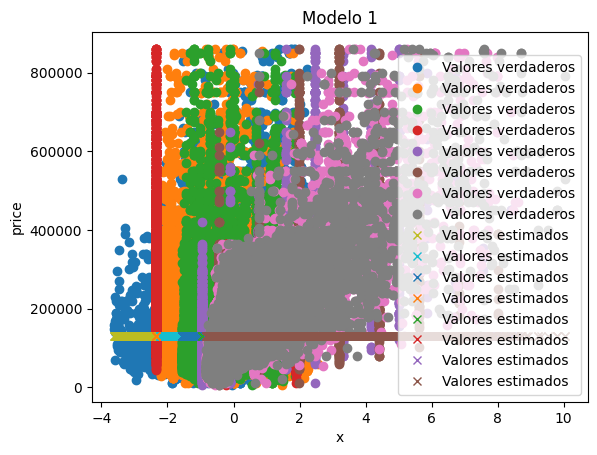

In [13]:
plot_regression(modelo,x_train_transform,y_train,title=f"Modelo 1",ylabel="price")

Vemos que el modelo entrenado al azar es muy malo en comparación de los datos reales. Por eso, procedemos a buscar los mejores parámetros para la red (units, es decir, cantidad de outputs y funciones de activación). En principio probamos utilizar otra arquitectura (le agregamos capas) a ver cómo resulta.
Nota: el modelo generado se guarda en una carpeta llamada "untitled_project" para evitar todo el entrenamiento cada vez que se quiere correr la notebook. En caso de necesitar correr la celda de entrenamiento de 0, borrar esa carpeta y correr 2 veces la celda correspondiente (una para crear el directorio y otra para ejecutar el entrenamiento).

In [14]:
#partimos la data de train en validación y train 80/20
x_train_cv, validation_x = train_test_split(x_train_transform, test_size=0.2, random_state=0)
print(len(x_train_cv))
print(len(validation_x))

y_train_cv, validation_y = train_test_split(y_train, test_size=0.2, random_state=0)
print(len(y_train_cv))
print(len(validation_y))

31775
7944
31775
7944


In [15]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
      hp.Choice('units', [2, 5, 10]),
      activation= hp.Choice("activation", ["relu", "tanh"])))
    model.add(keras.layers.Dense(
      hp.Choice('units', [2, 5, 10]),
      activation= hp.Choice("activation", ["relu", "tanh"])))
    model.add(keras.layers.Dense(1, activation= 'relu'))
    model.add(keras.layers.Dense(1, activation= 'exponential'))
    model.compile(loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

tuner.search(x_train_cv, y_train_cv, epochs=10, validation_data=(validation_x, validation_y)) 
best_model = tuner.get_best_models()[0]

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


1242/1242 [==============================] - 4s 3ms/step
       Valor Real     Prediccion          Error
0         79000.0  113411.023438   34411.023438
1         99000.0   93512.406250    5487.593750
2        160000.0  151252.703125    8747.296875
3        153000.0  130802.351562   22197.648438
4        159000.0  146740.281250   12259.718750
...           ...            ...            ...
39714    126900.0  107177.335938   19722.664062
39715    185000.0  140271.156250   44728.843750
39716    795000.0  511878.000000  283122.000000
39717    125000.0  118279.890625    6720.109375
39718     77000.0   88409.632812   11409.632812

[39719 rows x 3 columns]
El error más chico cometido es de USD 0.125
1242/1242 [==============================] - 4s 3ms/step


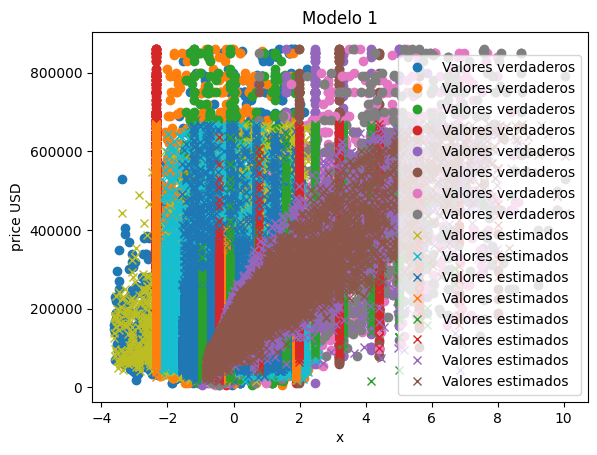

In [16]:
y_pred = best_model.predict(x_train_transform)
y_pred = y_pred.flatten()
error = y_train - y_pred
# Performance
performance = pd.DataFrame({'Valor Real': y_train,
                            'Prediccion': y_pred,
                            'Error':abs(error)})
print(performance)
print("El error más chico cometido es de USD", min(abs(error)))
plot_regression(best_model,x_train_transform,y_train,title=f"Modelo 1",ylabel="price USD")

El modelo alcanzado se logró luego de probar agregar o quitar capas probando ponerle diferentes funciones de activación como relu, exponencial, tanh y distintas cantidades de neuronas de salida. Vemos una amplia mejoría respecto al primero, este predice mucho mejor al precio de la propiedad en función de todas las demás variables numéricas. Vemos que se adapta mucho mejor a la forma del conjunto de datos.
Se realiza una imagen ilustrativa de la red:

![redneuronal.png](imagenes/best_neuronal_model_net.png)

Evaluamos en el conjunto de test:

309/309 [==============================] - 1s 3ms/step
      Valor Real     Prediccion         Error
0       220000.0  280820.031250  60820.031250
1        90000.0   73487.679688  16512.320312
2        85000.0  101874.500000  16874.500000
3       144000.0  140348.234375   3651.765625
4       105000.0  102714.257812   2285.742188
...          ...            ...           ...
9861     85000.0  101340.289062  16340.289062
9862    275000.0  192281.281250  82718.718750
9863    143900.0  142150.031250   1749.968750
9864    139500.0  188903.328125  49403.328125
9865    300000.0  257278.234375  42721.765625

[9866 rows x 3 columns]
El error más chico cometido es de USD 1.1640625
309/309 [==============================] - 1s 2ms/step


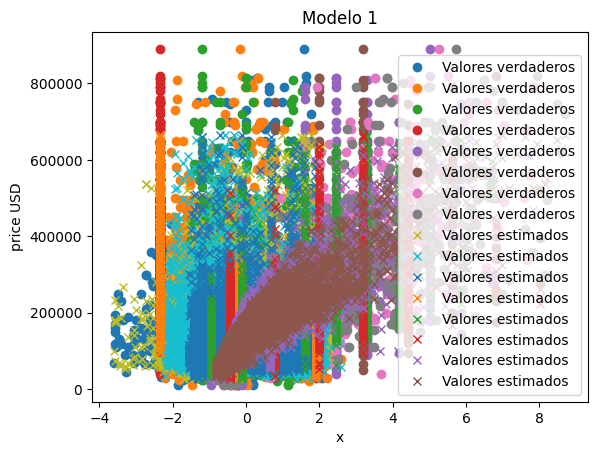

In [20]:
y_pred = best_model.predict(x_test_transform)
y_pred = y_pred.flatten()
error = y_test - y_pred
# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred,
                            'Error':abs(error)})
print(performance)
print("El error más chico cometido es de USD", min(abs(error)))
plot_regression(best_model,x_test_transform,y_test,title=f"Modelo 1",ylabel="price USD")

Nota: los colores de los valores verdaderos vs los estimados no tienen por qué coincidir, sólo son a modo de diferenciar features.

# Modelo: Clasificación

In [21]:
train_c = pd.read_csv("datasets/ds_con_tipo_precio_train.csv")
test_c = pd.read_csv("datasets/ds_con_tipo_precio_test.csv")

train_c.drop(["Unnamed: 0", "created_on", "provincia", "operation", "property_currency"], axis = 1, inplace=True)
test_c.drop(["Unnamed: 0", "created_on", "provincia", "operation", "property_currency"], axis = 1, inplace=True)

In [22]:
display(train_c.head())
display(test_c.head())

,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precio_metro_cuadrado,tipo_precio
0,-34.611523,-58.410394,BALVANERA,Departamento,1.0,1.0,49.0,45.0,79000.0,1612.244898,bajo
1,-34.621782,-58.424452,ALMAGRO,Departamento,1.0,1.0,44.0,40.0,99000.0,2250.000000,medio
2,-34.592425,-58.515042,VILLA DEVOTO,PH,3.0,2.0,76.0,66.0,160000.0,2105.263158,alto
3,-34.607836,-58.446965,CABALLITO,Departamento,2.0,1.0,56.0,50.0,153000.0,2732.142857,alto
4,-34.561456,-58.467606,BELGRANO,Departamento,2.0,1.0,55.0,45.0,159000.0,2890.909091,alto


,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precio_metro_cuadrado,tipo_precio
0,-34.552834,-58.491372,SAAVEDRA,PH,5.0,3.0,158.000000,115.0,220000.0,1392.405063,medio
1,-34.580101,-58.412473,PALERMO,PH,2.0,1.0,35.000000,32.0,90000.0,2571.428571,alto
2,-34.598510,-58.411857,ABASTO,Departamento,2.0,1.0,43.000000,41.0,85000.0,1976.744186,bajo
3,-34.567515,-58.458584,BELGRANO,Departamento,2.0,1.0,111.325111,44.0,144000.0,1293.508708,bajo
4,-34.588866,-58.416343,PALERMO,Departamento,2.0,1.0,39.000000,36.0,105000.0,2692.307692,alto


In [23]:
x_train_c = train_c.drop(columns="tipo_precio") 
y_train_c = label_encode(train_c, train_c, 'tipo_precio')
x_test_c = test_c.drop(columns='tipo_precio')
y_test_c = label_encode(test_c, test_c, 'tipo_precio')

x_train_c['barrio'] = label_encode(train_c, x_train_c, 'barrio')
x_test_c['barrio'] = label_encode(train_c, x_test_c, 'barrio')
x_train_c['property_type'] = label_encode(train_c, x_train_c, 'property_type')
x_test_c['property_type'] = label_encode(train_c, x_test_c, 'property_type')

display(x_train_c.head())
display(x_test_c.head())

x_train_c.head()

,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precio_metro_cuadrado
0,-34.611523,-58.410394,3,1,1.0,1.0,49.0,45.0,79000.0,1612.244898
1,-34.621782,-58.424452,2,1,1.0,1.0,44.0,40.0,99000.0,2250.000000
2,-34.592425,-58.515042,47,2,3.0,2.0,76.0,66.0,160000.0,2105.263158
3,-34.607836,-58.446965,9,1,2.0,1.0,56.0,50.0,153000.0,2732.142857
4,-34.561456,-58.467606,6,1,2.0,1.0,55.0,45.0,159000.0,2890.909091


,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precio_metro_cuadrado
0,-34.552834,-58.491372,37,2,5.0,3.0,158.000000,115.0,220000.0,1392.405063
1,-34.580101,-58.412473,26,2,2.0,1.0,35.000000,32.0,90000.0,2571.428571
2,-34.598510,-58.411857,0,1,2.0,1.0,43.000000,41.0,85000.0,1976.744186
3,-34.567515,-58.458584,6,1,2.0,1.0,111.325111,44.0,144000.0,1293.508708
4,-34.588866,-58.416343,26,1,2.0,1.0,39.000000,36.0,105000.0,2692.307692


,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precio_metro_cuadrado
0,-34.611523,-58.410394,3,1,1.0,1.0,49.0,45.0,79000.0,1612.244898
1,-34.621782,-58.424452,2,1,1.0,1.0,44.0,40.0,99000.0,2250.000000
2,-34.592425,-58.515042,47,2,3.0,2.0,76.0,66.0,160000.0,2105.263158
3,-34.607836,-58.446965,9,1,2.0,1.0,56.0,50.0,153000.0,2732.142857
4,-34.561456,-58.467606,6,1,2.0,1.0,55.0,45.0,159000.0,2890.909091


In [24]:
d_in = x_train_c.shape[1]
modelo_c = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 3 salidas, activación relu
    keras.layers.Dense(3,input_shape=(d_in,), activation='relu'),
    # Capa con 5 salidas, activación tanh
    keras.layers.Dense(5, activation='tanh'),
    #la ultima capa si o si tiene que tener tantas salidas como clases, y softmax 
    keras.layers.Dense(3, activation='softmax')])

modelo_c.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 33        
                                                                 
 dense_5 (Dense)             (None, 5)                 20        
                                                                 
 dense_6 (Dense)             (None, 3)                 18        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [25]:
modelo_c.compile(
    optimizer = keras.optimizers.SGD(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

modelo_c.fit(x_train_c, y_train_c, epochs=50, batch_size=64, verbose=False)

In [26]:
result = modelo_c.predict(x_train_c)

1242/1242 [==============================] - 3s 3ms/step


In [27]:
def obtener_prediccion(result):
    pred=[]
    for i in range(len(result)):
            clase_pred = (result[i]).argmax()
            pred.append(clase_pred)
    return pred

In [28]:
import seaborn as sns

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
              precisio

Text(50.722222222222214, 0.5, 'True')

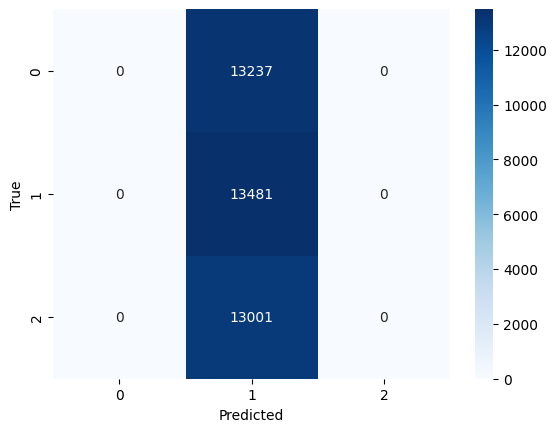

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
pred = obtener_prediccion(result)
# Reporte de Clasificación sobre train
print(classification_report(y_train_c,pred))

# Matriz de Confusión
cm = confusion_matrix(y_train_c,pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Como se puede apreciar, independientemente de los datos de entrada, este modelo siempre considera que el precio por m^2 de una propiedad es medio, lo cual supone una precisión bastante pobre del 33%.

A continuación, se crea un nuevo modelo de hiperparámetros específicos y entrenado en función de semillas para que sea un modelo reproducible.

Las funciones de pérdida y métrica elegidas fueron las de 'sparse_categorical_crossenptropy'. Esta decisióin se basó en el hecho de que se está creando un modelo clasificador, caso para el cual esta función está pensada. La razón por la que no se usó 'categorical_crossenptropy' se debe al formato de label encoding utilizado.

Además, esta red posee únicamente una capa de entrada (que recibe tantas entradas como campos hay) y una de salida (que devuelve tres salidas debido a la cantidad de clases potenciales). Este modelo devuelve, para cada predicción, un array con las probabilidades de pertenencia a cada una de las posibles clases.

In [30]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(7)

modelo_c = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 3 salidas, activación relu
    keras.layers.Dense(3,input_shape=(d_in,), activation='relu'),
    #la ultima capa si o si tiene que tener tantas salidas como clases, y softmax 
    keras.layers.Dense(3, activation='softmax')])

modelo_c.compile(
    optimizer = keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

modelo_c.fit(x_train_c, y_train_c, epochs=50, batch_size=64, verbose=False)

Probando el modelo con el dataset de entrenamiento, se puede evaluar un rendimiento considerablemente superior al del último modelo de clasificación.

1242/1242 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.87     13237
           1       0.82      0.91      0.87     13481
           2       0.77      0.65      0.71     13001

    accuracy                           0.82     39719
   macro avg       0.82      0.82      0.81     39719
weighted avg       0.82      0.82      0.81     39719



Text(50.722222222222214, 0.5, 'True')

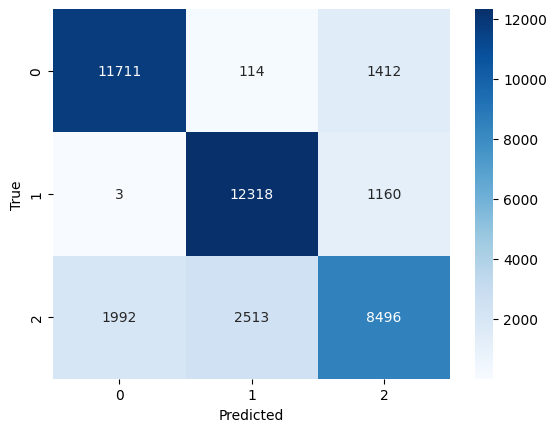

In [31]:
result = modelo_c.predict(x_train_c)

pred = obtener_prediccion(result)

# Reporte de Clasificación sobre train
print(classification_report(y_train_c,pred))

# Matriz de Confusión
cm = confusion_matrix(y_train_c,pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Un rendimiento muy similar se puede observar con el dataset de testing.

309/309 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      3294
           1       0.83      0.91      0.87      3405
           2       0.76      0.66      0.71      3167

    accuracy                           0.82      9866
   macro avg       0.82      0.82      0.82      9866
weighted avg       0.82      0.82      0.82      9866



Text(50.722222222222214, 0.5, 'True')

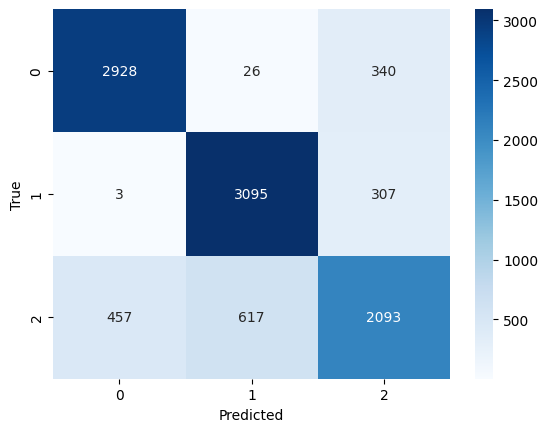

In [32]:
result = modelo_c.predict(x_test_c)

from sklearn.metrics import confusion_matrix, classification_report
pred = obtener_prediccion(result)

# Reporte de Clasificación sobre train
print(classification_report(y_test_c,pred))

# Matriz de Confusión
cm = confusion_matrix(y_test_c,pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8953c3ab-dbb1-46a7-ac7e-fe8a0929b2fc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>